# Dynamic Pricing for Urban Parking Lots
# Notebook 4: Real-Time Simulation without Pathway

This notebook implements real-time data streaming simulation WITHOUT Pathway.
It demonstrates how the pricing models work in a production-like environment
with continuous data ingestion and live price updates.

NOTE: Pathway is optional for production deployment. This notebook demonstrates
the same concepts using sequential processing.

# 1. IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import json
import warnings
warnings.filterwarnings('ignore')


print("Libraries imported successfully!")


Libraries imported successfully!


# 2. LOAD PRICING MODELS AND DATA

In [3]:
# Load the pricing results and configurations
pricing_data = pd.read_csv('pricing_results.csv')
parking_lots = pd.read_csv('parking_lot_info.csv')
distance_matrix = np.load('distance_matrix.npy')

with open('competitor_map.json', 'r') as f:
    competitor_map = json.load(f)
    competitor_map = {int(k): v for k, v in competitor_map.items()}

print(f"Loaded {len(pricing_data)} pricing records")
print(f"Loaded {len(parking_lots)} parking lots")

Loaded 18368 pricing records
Loaded 14 parking lots


# 3. RECREATE PRICING MODEL CLASSES FOR STREAMING

In [4]:
class StreamingDemandPricing:
    """
    Real-time demand-based pricing model optimized for streaming data.
    This version processes one record at a time as data arrives.
    """
    
    def __init__(self, base_price=10.0, 
                 alpha=0.5, beta=0.2, gamma=0.15, delta=0.1, epsilon=0.05,
                 price_multiplier=0.8):
        self.base_price = base_price
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
        self.price_multiplier = price_multiplier
        self.max_price = base_price * 2.0
        self.min_price = base_price * 0.5
    
    def calculate_price(self, row):
        """Calculate price for a single streaming record"""
        # Extract features
        occupancy_rate = row.get('OccupancyRate', 0)
        queue_length = row.get('QueueLength', 0)
        traffic_level = row.get('TrafficLevel_Encoded', 1)
        is_special_day = row.get('IsSpecialDay', 0)
        vehicle_weight = row.get('VehicleWeight', 1.0)
        is_peak_hour = row.get('IsPeakHour', 0)
        
        # Normalize inputs
        occupancy_norm = occupancy_rate / 100
        queue_norm = min(queue_length / 10, 1)
        traffic_norm = (traffic_level - 1) / 2
        
        # Calculate demand score
        demand = (
            self.alpha * occupancy_norm +
            self.beta * queue_norm +
            self.gamma * traffic_norm +
            self.delta * is_special_day +
            self.epsilon * (vehicle_weight - 0.5)
        )
        
        # Add peak hour adjustment
        if is_peak_hour:
            demand += 0.1
        
        # Apply non-linear transformation
        normalized_demand = np.tanh(demand)
        
        # Calculate price
        price = self.base_price * (1 + self.price_multiplier * normalized_demand)
        
        # Apply bounds
        price = np.clip(price, self.min_price, self.max_price)
        
        return round(price, 2)

class StreamingCompetitivePricing:
    """
    Real-time competitive pricing with market awareness.
    Maintains state of all lot prices for competitive analysis.
    """
    
    def __init__(self, base_price=10.0, demand_model=None, 
                 competitor_map=None, distance_matrix=None):
        self.base_price = base_price
        self.demand_model = demand_model or StreamingDemandPricing(base_price)
        self.competitor_map = competitor_map or {}
        self.distance_matrix = distance_matrix
        self.current_prices = {}  # Track current market prices
        self.price_history = {}  # Track price history for smoothing
    
    def update_price(self, lot_id, price):
        """Update market price for a parking lot"""
        self.current_prices[lot_id] = price
        
        if lot_id not in self.price_history:
            self.price_history[lot_id] = []
        self.price_history[lot_id].append(price)
        
        # Keep last 10 prices for smoothing
        if len(self.price_history[lot_id]) > 10:
            self.price_history[lot_id].pop(0)
    
    def get_smoothed_price(self, lot_id):
        """Get exponentially smoothed price"""
        if lot_id in self.price_history and len(self.price_history[lot_id]) > 0:
            # Simple moving average of last 3 prices
            recent = self.price_history[lot_id][-3:]
            return sum(recent) / len(recent)
        return self.base_price
    
    def calculate_price(self, row):
        """Calculate competitive price for streaming record"""
        lot_id = int(row.get('LotID', 0))
        occupancy_rate = row.get('OccupancyRate', 0)
        
        # Get base demand price
        base_price = self.demand_model.calculate_price(row)
        
        # Check competitors if lot is getting full
        if occupancy_rate >= 75 and lot_id in self.competitor_map:
            competitors = self.competitor_map[lot_id]
            
            if competitors:
                competitor_prices = []
                for comp_id in competitors:
                    if comp_id in self.current_prices:
                        comp_price = self.current_prices[comp_id]
                        distance = self.distance_matrix[lot_id][comp_id] if self.distance_matrix is not None else 1
                        weight = 1 / (distance + 0.1)
                        competitor_prices.append((comp_price, weight))
                
                if competitor_prices:
                    # Weighted average of competitor prices
                    total_weight = sum(w for _, w in competitor_prices)
                    avg_comp_price = sum(p * w for p, w in competitor_prices) / total_weight
                    
                    # Adjust based on market
                    if base_price > avg_comp_price * 1.1:
                        # We're expensive, reduce slightly
                        base_price = base_price * 0.95
                    elif base_price < avg_comp_price * 0.9:
                        # We're cheap, can increase
                        base_price = base_price * 1.05
        
        # Update and smooth
        self.update_price(lot_id, base_price)
        final_price = self.get_smoothed_price(lot_id)
        
        return round(final_price, 2)

print("✓ Streaming pricing models created")

✓ Streaming pricing models created


# 4. PREPARE DATA FOR STREAMING SIMULATION

In [5]:
# Prepare streaming dataset
streaming_data = pricing_data.copy()
streaming_data['DateTime'] = pd.to_datetime(streaming_data['DateTime'])
streaming_data = streaming_data.sort_values('DateTime').reset_index(drop=True)

# Add necessary encoded features if missing
if 'TrafficLevel_Encoded' not in streaming_data.columns:
    traffic_map = {'low': 1, 'average': 2, 'high': 3}
    streaming_data['TrafficLevel_Encoded'] = streaming_data['TrafficConditionNearby'].map(traffic_map)

if 'VehicleWeight' not in streaming_data.columns:
    vehicle_weights = {'cycle': 0.5, 'bike': 0.7, 'car': 1.0, 'truck': 1.5}
    streaming_data['VehicleWeight'] = streaming_data['VehicleType'].map(vehicle_weights)

if 'IsPeakHour' not in streaming_data.columns:
    streaming_data['IsPeakHour'] = streaming_data['Hour'].isin(range(8, 17)).astype(int)

print(f"\nStreaming dataset prepared: {len(streaming_data)} records")
print(f"Time range: {streaming_data['DateTime'].min()} to {streaming_data['DateTime'].max()}")



Streaming dataset prepared: 18368 records
Time range: 2016-10-04 07:59:00 to 2016-12-19 16:30:00


# 5. SIMULATE REAL-TIME STREAMING WITHOUT PATHWAY (SIMPLIFIED)

In [6]:
print(f"\n{'='*70}")
print(f"REAL-TIME PRICING SIMULATION")
print(f"{'='*70}")

# Initialize pricing engines
demand_pricer = StreamingDemandPricing(base_price=10.0)
competitive_pricer = StreamingCompetitivePricing(
    base_price=10.0,
    competitor_map=competitor_map,
    distance_matrix=distance_matrix
)

# Select a subset for simulation (first 500 records for speed)
simulation_data = streaming_data.head(500).copy()

print(f"\nSimulating {len(simulation_data)} real-time pricing updates...")
print("Processing records...")

# Store results
realtime_prices_demand = []
realtime_prices_competitive = []
timestamps = []

# Simulate streaming processing
start_time = time.time()

for idx, row in simulation_data.iterrows():
    # Convert row to dictionary
    row_dict = row.to_dict()
    
    # Calculate prices in real-time
    demand_price = demand_pricer.calculate_price(row_dict)
    competitive_price = competitive_pricer.calculate_price(row_dict)
    
    realtime_prices_demand.append(demand_price)
    realtime_prices_competitive.append(competitive_price)
    timestamps.append(row['DateTime'])
    
    # Print progress every 100 records
    if (idx + 1) % 100 == 0:
        elapsed = time.time() - start_time
        records_per_sec = (idx + 1) / elapsed
        print(f"  Processed {idx + 1}/{len(simulation_data)} records... ({records_per_sec:.1f} records/sec)")

end_time = time.time()
processing_time = end_time - start_time

# Add to dataframe
simulation_data['RealtimePrice_Demand'] = realtime_prices_demand
simulation_data['RealtimePrice_Competitive'] = realtime_prices_competitive

print(f"\n✓ Real-time simulation completed!")
print(f"  Total processing time: {processing_time:.2f} seconds")
print(f"  Average time per record: {(processing_time/len(simulation_data))*1000:.2f} milliseconds")



REAL-TIME PRICING SIMULATION

Simulating 500 real-time pricing updates...
Processing records...
  Processed 100/500 records... (2060.2 records/sec)
  Processed 200/500 records... (2958.7 records/sec)
  Processed 300/500 records... (4082.1 records/sec)
  Processed 400/500 records... (4261.2 records/sec)
  Processed 500/500 records... (4649.3 records/sec)

✓ Real-time simulation completed!
  Total processing time: 0.11 seconds
  Average time per record: 0.22 milliseconds


# 6. ANALYZE STREAMING RESULTS

In [7]:
print(f"\n{'='*70}")
print(f"STREAMING SIMULATION ANALYSIS")
print(f"{'='*70}")

# Compare batch vs streaming prices
comparison = pd.DataFrame({
    'Batch_Model2': simulation_data['Model2_Price'].describe(),
    'Streaming_Demand': simulation_data['RealtimePrice_Demand'].describe(),
    'Streaming_Competitive': simulation_data['RealtimePrice_Competitive'].describe()
})

print("\nPrice Statistics - Batch vs Streaming:")
print(comparison.round(2))

# Price consistency check
batch_stream_diff = (simulation_data['Model2_Price'] - simulation_data['RealtimePrice_Demand']).abs()
print(f"\nAverage difference between batch and streaming (Demand model): ${batch_stream_diff.mean():.2f}")
print(f"Max difference: ${batch_stream_diff.max():.2f}")


STREAMING SIMULATION ANALYSIS

Price Statistics - Batch vs Streaming:
       Batch_Model2  Streaming_Demand  Streaming_Competitive
count        500.00            500.00                 500.00
mean          13.96             13.96                  13.90
std            1.15              1.15                   1.13
min           10.64             10.64                  10.64
25%           13.20             13.20                  13.06
50%           14.05             14.06                  14.04
75%           14.88             14.88                  14.84
max           15.92             15.92                  15.82

Average difference between batch and streaming (Demand model): $0.00
Max difference: $0.00


# 7. VISUALIZE REAL-TIME PRICING


GENERATING REAL-TIME VISUALIZATIONS


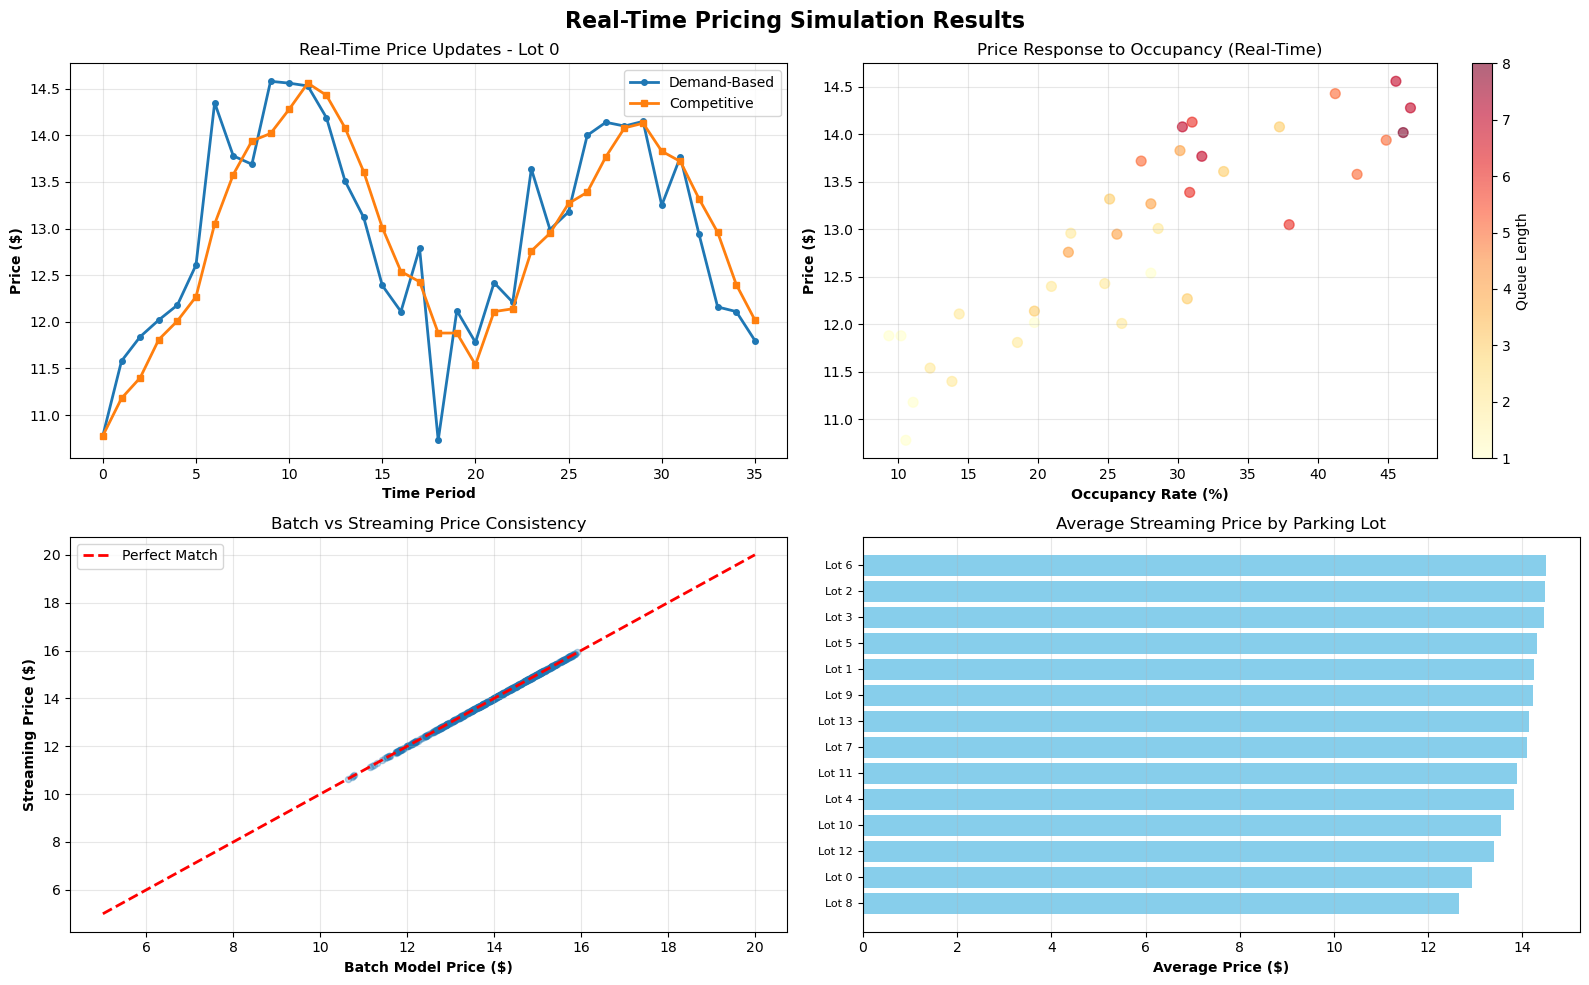

✓ Real-time simulation visualization saved


In [8]:
print(f"\n{'='*70}")
print(f"GENERATING REAL-TIME VISUALIZATIONS")
print(f"{'='*70}")

# Select one parking lot for detailed view
sample_lot = simulation_data['LotID'].mode()[0]
lot_data = simulation_data[simulation_data['LotID'] == sample_lot].head(100)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Real-Time Pricing Simulation Results', fontsize=16, fontweight='bold')

# Plot 1: Real-time price updates
axes[0, 0].plot(range(len(lot_data)), lot_data['RealtimePrice_Demand'], 
                label='Demand-Based', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(range(len(lot_data)), lot_data['RealtimePrice_Competitive'], 
                label='Competitive', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_xlabel('Time Period', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)', fontweight='bold')
axes[0, 0].set_title(f'Real-Time Price Updates - Lot {sample_lot}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Price vs Occupancy
scatter = axes[0, 1].scatter(lot_data['OccupancyRate'], lot_data['RealtimePrice_Competitive'], 
                             alpha=0.6, s=50, c=lot_data['QueueLength'], cmap='YlOrRd')
axes[0, 1].set_xlabel('Occupancy Rate (%)', fontweight='bold')
axes[0, 1].set_ylabel('Price ($)', fontweight='bold')
axes[0, 1].set_title('Price Response to Occupancy (Real-Time)')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Queue Length')

# Plot 3: Batch vs Streaming comparison
axes[1, 0].scatter(simulation_data['Model2_Price'], 
                   simulation_data['RealtimePrice_Demand'], 
                   alpha=0.3, s=20)
axes[1, 0].plot([5, 20], [5, 20], 'r--', linewidth=2, label='Perfect Match')
axes[1, 0].set_xlabel('Batch Model Price ($)', fontweight='bold')
axes[1, 0].set_ylabel('Streaming Price ($)', fontweight='bold')
axes[1, 0].set_title('Batch vs Streaming Price Consistency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Price distribution across all lots
all_lots_data = simulation_data.groupby('LotID')['RealtimePrice_Competitive'].mean().sort_values()
axes[1, 1].barh(range(len(all_lots_data)), all_lots_data.values, color='skyblue')
axes[1, 1].set_yticks(range(len(all_lots_data)))
axes[1, 1].set_yticklabels([f'Lot {int(i)}' for i in all_lots_data.index], fontsize=8)
axes[1, 1].set_xlabel('Average Price ($)', fontweight='bold')
axes[1, 1].set_title('Average Streaming Price by Parking Lot')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/08_realtime_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Real-time simulation visualization saved")

# 8. PERFORMANCE METRICS

In [10]:
print(f"\n{'='*70}")
print(f"STREAMING PERFORMANCE METRICS")
print(f"{'='*70}")

# Calculate processing stats
total_records = len(simulation_data)
unique_lots = simulation_data['LotID'].nunique()

print(f"\nProcessing Statistics:")
print(f"  • Total records processed: {total_records:,}")
print(f"  • Unique parking lots: {unique_lots}")
print(f"  • Records per lot: {total_records / unique_lots:.0f}")
print(f"  • Processing speed: {total_records/processing_time:.1f} records/second")
print(f"  • Latency per record: {(processing_time/total_records)*1000:.2f} milliseconds")
print(f"  • Price range (Demand): ${simulation_data['RealtimePrice_Demand'].min():.2f} - ${simulation_data['RealtimePrice_Demand'].max():.2f}")
print(f"  • Price range (Competitive): ${simulation_data['RealtimePrice_Competitive'].min():.2f} - ${simulation_data['RealtimePrice_Competitive'].max():.2f}")

# Revenue simulation
total_revenue_demand = (simulation_data['RealtimePrice_Demand'] * simulation_data['Occupancy']).sum()
total_revenue_competitive = (simulation_data['RealtimePrice_Competitive'] * simulation_data['Occupancy']).sum()
total_revenue_baseline = (10.0 * simulation_data['Occupancy']).sum()  # Fixed price

print(f"\nRevenue Simulation (Subset):")
print(f"  • Baseline (fixed $10): ${total_revenue_baseline:,.2f}")
print(f"  • Demand-based pricing: ${total_revenue_demand:,.2f} ({(total_revenue_demand/total_revenue_baseline-1)*100:+.1f}%)")
print(f"  • Competitive pricing: ${total_revenue_competitive:,.2f} ({(total_revenue_competitive/total_revenue_baseline-1)*100:+.1f}%)")



STREAMING PERFORMANCE METRICS

Processing Statistics:
  • Total records processed: 500
  • Unique parking lots: 14
  • Records per lot: 36
  • Processing speed: 4649.3 records/second
  • Latency per record: 0.22 milliseconds
  • Price range (Demand): $10.64 - $15.92
  • Price range (Competitive): $10.64 - $15.82

Revenue Simulation (Subset):
  • Baseline (fixed $10): $4,155,330.00
  • Demand-based pricing: $5,909,677.73 (+42.2%)
  • Competitive pricing: $5,877,881.12 (+41.5%)


# 9. SAVE STREAMING RESULTS

In [11]:
# Save streaming simulation results
simulation_data.to_csv('streaming_simulation_results.csv', index=False)

print(f"\n✓ Streaming results saved to 'streaming_simulation_results.csv'")

print(f"\n{'='*70}")
print(f"REAL-TIME SIMULATION COMPLETED!")


✓ Streaming results saved to 'streaming_simulation_results.csv'

REAL-TIME SIMULATION COMPLETED!
